# Туториал по языковым моделям на базе RNN

In [1]:
# # библиотека для BPE токенизации
# # https://github.com/VKCOM/YouTokenToMe
# !pip install youtokentome

### Импортирование библиотек

In [2]:
import math
import numpy as np
import pandas as pd

import random
import json
import torch
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

from matplotlib import pyplot as plt

import youtokentome as yttm

In [3]:
# для языковой модели мы будем использовать неразмеченные вопросы
questions = pd.read_csv('unsupervised.csv')
questions.question = questions.question.map(lambda x: x.lower())

In [4]:
questions.head(10)

,question
0,"положено ли пособие опекаемому ребенку, обучаю..."
1,где скачать прогу для записи видео онлайн. зар...
2,физика амперы метрология помогите
3,"имеет ли многодетная семья ""скидку"" на услуги ..."
4,пенсия по инвалидности и старости...
5,"назовите несколько инженерных специальностей, ..."
6,в ваших iq тестах есть вопросы на знание унита...
7,какие обязанности у уборщицы в отделении реани...
8,что с работой уходить или оставаться?
9,как из корня имбиря выжать сок ??(чтоб чуток р...


## Обучение BPE

In [5]:
# для "обучения" bpe модели нам нужно сохранить данные для обучения в отдельный файл
# где будут построчно храниться тексты
# раскомментируйте этот код, чтобы собрать такой файл
with open('for_bpe.txt', 'w', encoding='utf-8') as f:
    for que in questions.question:
        f.write(que + '\n')
        
# параметры
vocab_size = 30_000
model_path = 'pretrained_bpe_lm.model'

In [6]:
%%time
# обучаем
# раскомментируйте этот код, чтобы обучить bpe
yttm.BPE.train(data='for_bpe.txt', vocab_size=vocab_size, model=model_path)

CPU times: user 24.3 s, sys: 7.09 s, total: 31.4 s
Wall time: 8.82 s


In [7]:
# загружаем токенизатор
tokenizer = yttm.BPE(model=model_path)

In [8]:
tokenizer.vocab()[:15]

['<PAD>',
 '<UNK>',
 '<BOS>',
 '<EOS>',
 '▁',
 'о',
 'а',
 'е',
 'т',
 'и',
 'н',
 'с',
 'р',
 'к',
 'л']

In [9]:
# пример токенизации с выводом на уровне сабвордов
tokenizer.encode(list(questions.question[:2]), bos=True, eos=True, output_type=yttm.OutputType.SUBWORD)

[['<BOS>',
  '▁положено',
  '▁ли',
  '▁пособие',
  '▁опека',
  'емо',
  'му',
  '▁ребен',
  'ку,',
  '▁обуча',
  'ющему',
  'ся',
  '▁в',
  '▁колледже',
  ',',
  '▁после',
  '▁18',
  '▁лет?',
  '<EOS>'],
 ['<BOS>',
  '▁где',
  '▁скачать',
  '▁прогу',
  '▁для',
  '▁записи',
  '▁видео',
  '▁онлайн.',
  '▁заранее',
  '▁благодарен',
  '!',
  '<EOS>']]

In [10]:
# пример токенизации с выводом на уровне индексов
# как раз это нам и понадобится
tokenizer.encode(list(questions.question[:2]), bos=True, eos=True)

[[2,
  17159,
  1827,
  6986,
  22120,
  3393,
  1936,
  2800,
  2973,
  16624,
  9760,
  1820,
  1774,
  10516,
  31,
  2083,
  2866,
  3228,
  3],
 [2, 1960, 3076, 7139, 1907, 6317, 2264, 22772, 3441, 8381, 45, 3]]

In [11]:
# проверим нет ли пропусков
questions.isna().sum()

question    0
dtype: int64

In [12]:
# давайте токенизируем наш датасет
# токенизирую батчами, потому что так быстрее
# также в начало добавляем токен bos (begin of sentence)
# и в конец токен eos (end of sentence)

tokenized = []

batch_size = 256

for i_batch in tqdm(range(math.ceil(len(questions.question) / batch_size))):
    
    tokenized.extend(tokenizer.encode(
        list(questions.question[i_batch*batch_size:(i_batch+1)*batch_size]), bos=True, eos=True))

100%|██████████| 9905/9905 [00:20<00:00, 481.85it/s]


### Формат данных

По последовательности "мама мыла" нужно предсказать последовательность "мыла раму". Передаешь последовательность из двух слов в сетку "мама мыла" и получаешь предсказания такой же длины. Для каждого слова из исходной последовательности предсказать следующее слово.

То есть по слову "мама" предсказать "мыла", а по слову "мыла" при условии, что предыдущее слово было "мама", предсказать следующее слово "раму". Вот именно это понятие "при условии, что предыдущее слово было" реализует RNN за счет памяти от состояния к состоянию.

In [13]:
sequence = 'чем бы мне заняться на выходных'.split()

source_sequence = ['bos'] + sequence
target_sequence = sequence + ['eos']

In [14]:
for n in range(len(source_sequence)):
    print(f'По токену "{source_sequence[n]}" предсказываем токен "{target_sequence[n]}"')
    print('Или с точки зрения rnn')
    message = f'По токену "{source_sequence[n]}" при условии того, что в памяти есть {source_sequence[:n]}'
    message += f' предсказываем токен "{target_sequence[n]}"'
    print(message)
    print()

По токену "bos" предсказываем токен "чем"
Или с точки зрения rnn
По токену "bos" при условии того, что в памяти есть [] предсказываем токен "чем"

По токену "чем" предсказываем токен "бы"
Или с точки зрения rnn
По токену "чем" при условии того, что в памяти есть ['bos'] предсказываем токен "бы"

По токену "бы" предсказываем токен "мне"
Или с точки зрения rnn
По токену "бы" при условии того, что в памяти есть ['bos', 'чем'] предсказываем токен "мне"

По токену "мне" предсказываем токен "заняться"
Или с точки зрения rnn
По токену "мне" при условии того, что в памяти есть ['bos', 'чем', 'бы'] предсказываем токен "заняться"

По токену "заняться" предсказываем токен "на"
Или с точки зрения rnn
По токену "заняться" при условии того, что в памяти есть ['bos', 'чем', 'бы', 'мне'] предсказываем токен "на"

По токену "на" предсказываем токен "выходных"
Или с точки зрения rnn
По токену "на" при условии того, что в памяти есть ['bos', 'чем', 'бы', 'мне', 'заняться'] предсказываем токен "выходных"


In [15]:
class LanguageModelData(torch.utils.data.Dataset):
    
    def __init__(self, data, max_len, pad_index, eos_index):
        
        self.data = data
        
        self.max_len = max_len
        
        self.pad_index = pad_index
        self.eos_index = eos_index
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        
        sequence = self.data[index][:self.max_len]
        
        # исходная последовательность
        x = sequence[:]
        # нужно предсказать смещенную последовательность
        y = sequence[1:] + [self.eos_index]
        
        assert len(x) == len(y)
        
        pads = [self.pad_index] * (self.max_len - len(x))
        
        x = torch.tensor(x + pads).long()
        y = torch.tensor(y + pads).long()
        
        return x, y

In [16]:
# надо выбрать максимальную длину
lengths = np.array([len(x) for x in tokenized])
np.percentile(lengths, q=95)

28.0

In [17]:
tokenizer.vocab()[:15]

['<PAD>',
 '<UNK>',
 '<BOS>',
 '<EOS>',
 '▁',
 'о',
 'а',
 'е',
 'т',
 'и',
 'н',
 'с',
 'р',
 'к',
 'л']

In [18]:
batch_size = 64

max_len = 32

pad_index = 0
eos_index = 3

In [19]:
random.shuffle(tokenized)

validation_start_index = int(len(tokenized) * 0.05)

In [20]:
train_dataset = LanguageModelData(data=tokenized[:-validation_start_index], max_len=max_len, 
                                  pad_index=pad_index, eos_index=eos_index)
validation_dataset = LanguageModelData(data=tokenized[-validation_start_index:], max_len=max_len,
                                       pad_index=pad_index, eos_index=eos_index)

len(train_dataset), len(validation_dataset)

(2408671, 126772)

In [21]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size)

In [22]:
for x, y in train_loader:
    break

In [23]:
x

tensor([[    2,  1797, 21508,  ...,     0,     0,     0],
        [    2, 18923,  2009,  ...,     0,     0,     0],
        [    2,  4637,  7732,  ...,     0,     0,     0],
        ...,
        [    2,  1846,  2053,  ...,     0,     0,     0],
        [    2,  1817,  2079,  ...,     0,     0,     0],
        [    2, 29502,  3762,  ...,     0,     0,     0]])

In [24]:
y

tensor([[ 1797, 21508,  2967,  ...,     0,     0,     0],
        [18923,  2009,  1817,  ...,     0,     0,     0],
        [ 4637,  7732, 10694,  ...,     0,     0,     0],
        ...,
        [ 1846,  2053,  2872,  ...,     0,     0,     0],
        [ 1817,  2079,  4059,  ...,     0,     0,     0],
        [29502,  3762, 12255,  ...,     0,     0,     0]])

In [25]:
# первое слово в source равняется нулевому слову в target
x[:, 1] == y[:, 0]

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True])

In [26]:
# пробежимся по итератору, чтобы убедиться что ничего не падает и он работает достаточно быстро

progress_bar = tqdm(total=len(validation_loader.dataset), desc='Testing')

for x, y in validation_loader:
    progress_bar.update(x.size(0))
    
progress_bar.close()

Testing: 100%|██████████| 126772/126772 [00:02<00:00, 55790.47it/s]


In [27]:
class LanguageModel(torch.nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, model_dim, num_layers, dropout, padding_idx):
        
        super().__init__()
        
        # просто эмбеддинги
        self.embedding_layer = torch.nn.Embedding(num_embeddings=vocab_size, 
                                                  embedding_dim=embedding_dim,
                                                  padding_idx=padding_idx)
        
        # просто lstm
        self.lstm = torch.nn.LSTM(input_size=embedding_dim, 
                                  hidden_size=model_dim,
                                  num_layers=num_layers, 
                                  dropout=0.3,
                                  batch_first=True)
        
        # выходная матрица эмбеддингов
        # количество выходных фичей равно размеру словаря
        # то есть это задача мультиклассовой классификации, но только классов очень много
        self.language_model_head = torch.nn.Linear(in_features=model_dim,
                                                   out_features=vocab_size,
                                                   bias=False)
        
    def forward(self, x):
        
        x = self.embedding_layer(x)
        
        x, _ = self.lstm(x)
        
        # к каждому элементу последовательности применяется выходная матрица эмбеддингов, 
        # которая переводит вектор lstm в предсказание конкретного слова
        x = self.language_model_head(x)
        
        return x

###  Device

Таким образом задается девайс, на котором мы будем обучаться. Мы можем указать либо гпу (вплоть до конкретной карты), либо цпу. В этой домашке нам обязательно понадобится гпу, так как на цпу обучение будет занимать слишко долгое время.

Используйте для гпу такие сервисы:  
Бесплатный: https://colab.research.google.com/  

Почти бесплатный: https://vast.ai  
Хороший выбор машины с гпу - 1080TI  
Стоимость такой машины примерно 8 рублей в час

In [28]:
assert torch.cuda.is_available(), 'у вас не находится гпу'

device = torch.device('cuda:1')

In [29]:
embedding_dim = 128
model_dim = 128
num_layers = 2
dropout = 0.35

In [30]:
model = LanguageModel(vocab_size=vocab_size, embedding_dim=embedding_dim,
                      model_dim=model_dim, num_layers=num_layers,
                      dropout=dropout, padding_idx=pad_index)
model.to(device)

LanguageModel(
  (embedding_layer): Embedding(30000, 128, padding_idx=0)
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.3)
  (language_model_head): Linear(in_features=128, out_features=30000, bias=False)
)

In [31]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [32]:
print(f'Количество обучаемых параметров в сети: {count_parameters(model):,}')

Количество обучаемых параметров в сети: 7,944,192


In [33]:
x = x.to(device)
y = y.to(device)

In [34]:
# проверим все ли корректно предсказывается
with torch.no_grad():
    pred = model(x)

In [35]:
pred.shape

torch.Size([52, 32, 30000])

In [36]:
# у нас есть тег eos (end of sentence), который есть в каждом тренировочном примере
# мы не будем считать лосс для падов
# вместо этого будем останавливать генерирование моделью в момент, когда она сгенерирует тег eos
# 
criterion = torch.nn.CrossEntropyLoss(ignore_index=pad_index)
optimizer = torch.optim.Adam(params=model.parameters())

In [37]:
# развернем все наши предсказания в один большой батч
# наши предсказания и наши таргеты сохраняют свое местоположение
# а пады не учитываются в расчете лосса
pred.view(-1, pred.size(-1)).shape, y.view(-1).shape

(torch.Size([1664, 30000]), torch.Size([1664]))

In [38]:
# и за счет этого вот так просто можем посчитать лосс для всего батча и для всех таймстемпов

loss = criterion(pred.view(-1, pred.size(-1)), y.view(-1))

loss.item()

10.312191009521484

In [39]:
# функция для обучения одной эпохи
# почти все как всегда

def train(model, loader, criterion, optimizer, last_n_losses=500, verbose=True):
    
    losses = []

    progress_bar = tqdm(total=len(loader), disable=not verbose, desc='Train')

    model.train()

    for x, y in loader:

        x = x.to(device)
        y = y.to(device)

        pred = model(x)

        loss = criterion(pred.view(-1, pred.size(-1)), y.view(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        progress_bar.set_postfix(loss=np.mean(losses[-last_n_losses:]),
                                 perplexity=np.exp(np.mean(losses[-last_n_losses:])))

        progress_bar.update()

    progress_bar.close()
    
    return losses

In [40]:
# обратите внимание, что будем тестироваться (именно коректность кода) на валидационном датасете
# нам сейчас важно понять, что все работает
# код не падает, лосс снижается
# валидационный датасет сильно меньше тренировочного и давайте будем тестироваться (понять, что все работает) на нем
epoch_losses = train(model, validation_loader, criterion, optimizer)

Train: 100%|██████████| 1981/1981 [00:33<00:00, 58.28it/s, loss=6.91, perplexity=1e+3]   


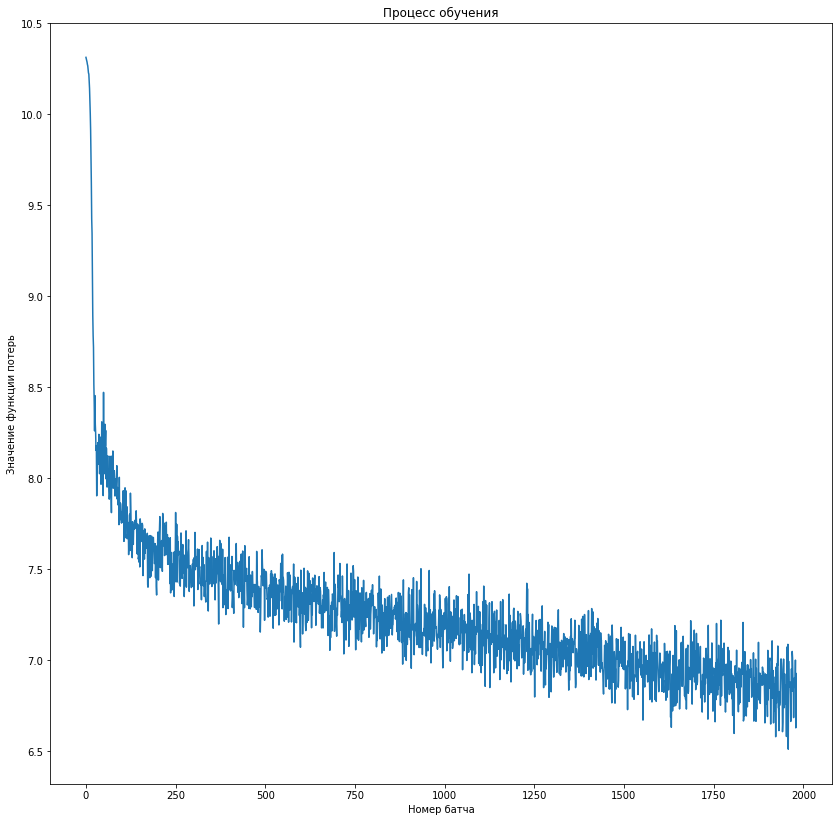

In [41]:
plt.figure(figsize=(14, 14))
plt.xlabel('Номер батча')
plt.ylabel('Значение функции потерь')
plt.title('Процесс обучения')
plt.plot(epoch_losses)

In [42]:
# фукнция для расчета метрик на тесте

def evaluate(model, loader, criterion, last_n_losses=500, verbose=True):
    
    losses = []

    progress_bar = tqdm(total=len(loader), disable=not verbose, desc='Evaluate')

    model.eval()

    for x, y in loader:

        x = x.to(device)
        y = y.to(device)

        with torch.no_grad():
            pred = model(x)

        loss = criterion(pred.view(-1, pred.size(-1)), y.view(-1))

        losses.append(loss.item())

        progress_bar.set_postfix(loss=np.mean(losses[-last_n_losses:]),
                                 perplexity=np.exp(np.mean(losses[-last_n_losses:])))

        progress_bar.update()

    progress_bar.close()
    
    return losses

In [43]:
val_losses = evaluate(model, validation_loader, criterion)
f'Val loss - {np.mean(val_losses):.3f} perplexity - {np.exp(np.mean(val_losses)):.3f}'

Evaluate: 100%|██████████| 1981/1981 [00:14<00:00, 139.33it/s, loss=6.68, perplexity=796]


'Val loss - 6.765 perplexity - 866.874'

In [44]:
# это специальный дропаут для реккуретных сетей
# хорошо это объясняется здесь: https://youtu.be/WLaAIYQHHMU?t=1093

class SpatialDropout(torch.nn.Dropout2d):
    
    def __init__(self, p=0.5):
        super().__init__()
        self.p = p
    
    def forward(self, x):
        x = x.unsqueeze(2)    # (N, T, 1, K)
        x = x.permute(0, 3, 2, 1)  # (N, K, 1, T)
        x = super(SpatialDropout, self).forward(x)  # (N, K, 1, T)
        x = x.permute(0, 3, 2, 1)  # (N, T, 1, K)
        x = x.squeeze(2)  # (N, T, K)
        return x

In [45]:
spatial_dropout = SpatialDropout()
common_dropout = torch.nn.Dropout()

In [46]:
# пусть у нас есть какой батч с размером батча 2 пример, 4 длиной последовательности и 8 размеров эмбеддинга
z = torch.rand(2, 4, 6)

In [47]:
z

tensor([[[0.2343, 0.0815, 0.4016, 0.8253, 0.5249, 0.8391],
         [0.4733, 0.9123, 0.2109, 0.2206, 0.4730, 0.1146],
         [0.7692, 0.1277, 0.8900, 0.6446, 0.3263, 0.7620],
         [0.4521, 0.9696, 0.6628, 0.5838, 0.7607, 0.7098]],

        [[0.7371, 0.4247, 0.8642, 0.1821, 0.4250, 0.6249],
         [0.6614, 0.7795, 0.2987, 0.9362, 0.6121, 0.0543],
         [0.4832, 0.3873, 0.4724, 0.5110, 0.8277, 0.7672],
         [0.4431, 0.9859, 0.2180, 0.2147, 0.7895, 0.3397]]])

In [48]:
# этот дропаут выкидывает значения для какого-либо размерности для каждого элемента последовательности
# чем это лучше обычного дропаута в реккуретных сетях можно посмотреть опять-таки здесь: https://youtu.be/WLaAIYQHHMU?t=1093
spatial_dropout(z)

tensor([[[0.0000, 0.1630, 0.8032, 1.6506, 1.0499, 1.6782],
         [0.0000, 1.8245, 0.4218, 0.4412, 0.9461, 0.2293],
         [0.0000, 0.2554, 1.7800, 1.2891, 0.6527, 1.5240],
         [0.0000, 1.9392, 1.3256, 1.1675, 1.5214, 1.4195]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.2497],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1087],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.5345],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6794]]])

In [49]:
# а вот так работает простой дропаут
common_dropout(z)

tensor([[[0.4686, 0.0000, 0.8032, 1.6506, 0.0000, 1.6782],
         [0.9467, 1.8245, 0.0000, 0.4412, 0.0000, 0.0000],
         [0.0000, 0.0000, 1.7800, 1.2891, 0.6527, 1.5240],
         [0.9042, 1.9392, 1.3256, 1.1675, 1.5214, 0.0000]],

        [[1.4741, 0.8494, 0.0000, 0.3641, 0.0000, 1.2497],
         [0.0000, 1.5591, 0.0000, 0.0000, 1.2242, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 1.6554, 0.0000],
         [0.0000, 1.9718, 0.0000, 0.4294, 0.0000, 0.6794]]])

In [50]:
# заметим, что входные и выходные эмбеддинги имеют одинаковую размерность
# точней они могут иметь не одинаковую, но мы можем сделать ее одинаковой
# и мы можем сделать такую вещь как weight tying
# когда выходящие эмбеддинги шарят веса с входящими
# это полезно делать, потому что, как правило, матрица эмбеддингов занимает самую большую долю всех весов в сети
# а в языковой модели у нас целых 2 такие матрицы
# давайте выходной слой будет ссылаться (шарить) на веса входящего слоя эмбеддингов

model.embedding_layer.weight.shape, model.language_model_head.weight.shape

(torch.Size([30000, 128]), torch.Size([30000, 128]))

In [51]:
class LanguageModel(torch.nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, model_dim, num_layers,
                 padding_idx, dropout=0.35, weight_tying=True):
        
        super().__init__()
        
        self.embedding_layer = torch.nn.Embedding(num_embeddings=vocab_size,
                                                  embedding_dim=embedding_dim, padding_idx=padding_idx)
        
        self.embedding_dropout = SpatialDropout(p=dropout)
        
        self.lstm = torch.nn.LSTM(input_size=embedding_dim, hidden_size=model_dim, 
                                  num_layers=num_layers, dropout=dropout, batch_first=True)
        
        self.language_model_head = torch.nn.Linear(in_features=model_dim, out_features=vocab_size, bias=False)
        
        # как раз здесь задаем, чтобы веса входящего и выходящего слоя эмбеддингов шарились
        if weight_tying and embedding_dim == model_dim:
            self.language_model_head.weight = self.embedding_layer.weight
        
    def forward(self, x):
        
        x = self.embedding_layer(x)
        
        x = self.embedding_dropout(x)
        
        x, _ = self.lstm(x)
        
        x = self.language_model_head(x)
        
        return x

In [52]:
model = LanguageModel(vocab_size=vocab_size, embedding_dim=embedding_dim, model_dim=model_dim, 
                      num_layers=num_layers, dropout=dropout, padding_idx=pad_index, weight_tying=True)

In [53]:
print(f'Количество обучаемых параметров в сети: {count_parameters(model):,}')
print('Их стало сильно меньше за счет weight tying!')

Количество обучаемых параметров в сети: 4,104,192
Их стало сильно меньше за счет weight tying!


In [54]:
model.to(device)
optimizer = torch.optim.Adam(params=model.parameters())

In [55]:
epoch_losses = train(model, validation_loader, criterion, optimizer)

Train: 100%|██████████| 1981/1981 [00:32<00:00, 60.52it/s, loss=7.29, perplexity=1.46e+3]


### Метрики стали хуже, но на долгосрочную переспективу они будут лучше

In [56]:
# вот что происходит внутри сети

# переключаем в режим предсказаний
model.eval()

with torch.no_grad():
    
    emb = model.embedding_layer(x)

    emb = model.embedding_dropout(emb)

    lstm_out, _ = model.lstm(emb)

    prediction = model.language_model_head(lstm_out)
    
# переключаем в режим тренировки обратно
model.train()

# считаем функцию потерь
criterion(prediction.view(-1, pred.size(-1)), y.view(-1)).item()

7.29207181930542

In [57]:
prediction.shape

torch.Size([52, 32, 30000])

In [58]:
# давайте распишем подробнее
# как lstm итерируется по каждому таймстемпу

# переключаем в режим предсказаний
model.eval()

with torch.no_grad():
    
    # массив для предсказаний нашей последовательности
    pred = []
    
    # инициализация памяти для lstm
    zeros = torch.zeros(num_layers, x.size(0), model_dim, dtype=torch.float32, device=x.device)
    hx = (zeros, zeros)
    
    # цикл по временной последовательности
    for timestamp in range(x.size(1)):
        
        # выбираем на каждому шаге очередной токен и добавляем размерность будто у нас предложения из 1 токена
        current_token = x[:, timestamp].unsqueeze(1)
        
        emb = model.embedding_layer(current_token)

        emb = model.embedding_dropout(emb)

        # рассчитываем предикт lstm и обновляем память
        lstm_out, hx = model.lstm(emb, hx)

        # предсказываем следующий токен
        next_token_prediction = model.language_model_head(lstm_out)
        
        # добавляем в массив предсказаний
        pred.append(next_token_prediction)
       
    # конкатерируем в последовательность
    pred = torch.cat(pred, dim=1)
    
# переключаем в режим тренировки обратно
model.train()
    
# считаем функцию потерь
criterion(pred.view(-1, pred.size(-1)), y.view(-1)).item()

7.29207181930542

### Генерация
В конце туториала мы будем использовать текст, чтобы его продолжить, а сейчас используем на вход только токен bos (begin of sentence)

In [59]:
model.eval()

with torch.no_grad():
    
    pred = []
    
    zeros = torch.zeros(num_layers, x.size(0), model_dim, dtype=torch.float32, device=x.device)
    hx = (zeros, zeros)
    
    # семплируем начальный токен bos для каждого предложения
    current_token = x[:, 0].unsqueeze(1)
    
    for timestamp in range(x.size(1)):
        
        # пока все то же самое
        emb = model.embedding_layer(current_token)

        emb = model.embedding_dropout(emb)

        lstm_out, hx = model.lstm(emb, hx)

        next_token_prediction = model.language_model_head(lstm_out)
        
        pred.append(next_token_prediction)
        
        # но вот здесь мы семплируем предсказания сети и передадим это как текущий токен для следующего таймстемпа
        current_token = next_token_prediction.argmax(dim=2)
        
    pred = torch.cat(pred, dim=1)
    
model.train()
    
tokens = pred.argmax(dim=-1).detach().cpu().numpy()

In [60]:
# вот что мы предсказали
tokens

array([[1797, 2395, 1774, ...,    3,    3,    3],
       [1797, 2395, 1774, ...,    3,    3,    3],
       [1797, 2395, 1774, ...,    3,    3,    3],
       ...,
       [1797, 2395, 1774, ...,    3,    3,    3],
       [1797, 2395, 1774, ...,    3,    3,    3],
       [1797, 2395, 1774, ...,    3,    3,    3]])

In [61]:
predicted_texts = tokenizer.decode(tokens.tolist())

In [62]:
for n in range(5):
    print(predicted_texts[n][:predicted_texts[n].index('<EOS>')])
    
# они все одинаковые, потому что на вход подается один и тот же токен <BOS>, а веса модели зафиксированы

как называется в москве
как называется в москве
как называется в москве
как называется в москве
как называется в москве


### Результаты генерации

Достаточно неплохо для 30 секунд обучения.

### Sequence bucketing

Наша модель никак не привязана к длине последовательности, привязана только лишь читалка данных и мы искуственно ограничиваем длину наших примеров.

Мы можем обрубать длины примеров в нашем батче до максимальной длины в батче, но батче могут быть 63 примера с длиной, допустим, 10 и 1 пример с длиной в 31 слова. В этом случае мы обрубим длину только лишь на один токен и будем тратить лишнее время итерируясь по нулям, которые нам не нужны.

Может стоит отсортировать датасет и идти от самого маленького к самому большому примеру или наоброт. Еще большая проблема, потому что, как минимум, предложения разной длины несут разный смысл. И наша сеть по мере обучения будет от эпохи к эпохе стараться адаптироваться то к маленьким, то к большим последовательностям. Это очень плохо.

А давайте мы тогда составим наши батчи с примерно одинаковой длиной, зашафлим данные на уровне батче и будем итерироваться по батчам с одинаковой длиной. То есть у нас будет то длиный батч, то короткий, то средний, то есть мы не будем привязываться к длине.

Ниже достаточно простой (но не единственный и далеко не оптимальный) способ это сделать.

In [63]:
tokenized = sorted(tokenized, key=lambda x: len(x))

# сделаем батч побольше
batch_size = 256

batches = []

for i_batch in range(math.ceil(len(tokenized) / batch_size)):
    
    batches.append(tokenized[i_batch*batch_size:(i_batch+1)*batch_size])

In [64]:
len(batches)

9905

In [65]:
random.shuffle(batches)

In [66]:
[len(sample) for sample in random.choice(batches)][:5]

[22, 22, 22, 22, 22]

In [67]:
class SequenceBucketingData(torch.utils.data.Dataset):
    
    def __init__(self, data, max_len, pad_index, eos_index):
        
        self.data = data
        
        self.max_len = max_len
        
        self.pad_index = pad_index
        self.eos_index = eos_index
        
    def __len__(self):
        return len(self.data)
    
    def prepare_sample(self, sequence, max_len):
        
        sequence = sequence[:max_len]
        
        x = sequence[:]
        y = sequence[1:] + [self.eos_index]
        
        assert len(x) == len(y)
        
        pads = [self.pad_index] * (max_len - len(x))
        
        x += pads
        y += pads
        
        return x, y
    
    def __getitem__(self, index):
        
        batch = self.data[index]
        
        max_len = min([self.max_len, max([len(sample) for sample in batch])])
        
        batch_x = []
        batch_y = []
        
        for sample in batch:
            x, y = self.prepare_sample(sample, max_len)
            batch_x.append(x)
            batch_y.append(y)
        
        batch_x = torch.tensor(batch_x).long()
        batch_y = torch.tensor(batch_y).long()
        
        return batch_x, batch_y

In [68]:
validation_start_index = int(len(batches) * 0.05)

In [69]:
train_dataset = SequenceBucketingData(batches[:-validation_start_index], max_len, pad_index, eos_index)
validation_dataset = SequenceBucketingData(batches[-validation_start_index:], max_len, pad_index, eos_index)

In [70]:
# чтобы убрать лишнюю размерность

def collate_fn(x):
    
    x, y = x[0]

    return x, y

In [71]:
# ставим batch_size=1 потому что датасет уже отдает батч
# добавим shuffle=True
# за счет этого флага каждую эпоху датасет перемешивается

# collate_fn это функция, с помощью которой можно задать свою логику сборки батча

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=1,
                                           collate_fn=collate_fn,
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(validation_dataset,
                                                batch_size=1,
                                                collate_fn=collate_fn, 
                                                shuffle=True)

In [72]:
# пробежимся по итератору, чтобы убедиться что ничего не падает и он работает достаточно быстро

progress_bar = tqdm(total=len(validation_loader.dataset), desc='Testing')

for x, y in validation_loader:
    progress_bar.update()
    
progress_bar.close()

Testing: 100%|██████████| 495/495 [00:00<00:00, 800.93it/s]


In [73]:
x

tensor([[    2,  2580,  1827,  ..., 12980,  2561,     3],
        [    2,  2170, 13856,  ...,  4200,  3496,     3],
        [    2,  1808,  9944,  ...,  2607,  2090,     3],
        ...,
        [    2,  3031,    45,  ...,  2202,  2423,     3],
        [    2,  5051,  2168,  ..., 28310,  1905,     3],
        [    2,  1816,  2327,  ..., 15791,  2423,     3]])

In [74]:
y

tensor([[ 2580,  1827,  1908,  ...,  2561,     3,     3],
        [ 2170, 13856,  6368,  ...,  3496,     3,     3],
        [ 1808,  9944, 15543,  ...,  2090,     3,     3],
        ...,
        [ 3031,    45,  1822,  ...,  2423,     3,     3],
        [ 5051,  2168,  1774,  ...,  1905,     3,     3],
        [ 1816,  2327,  1828,  ...,  2423,     3,     3]])

### Добавим в обучение gradient clipping

Эта техника помогает меньше влиять взрыву градиента за счет того, что мы нормируем наши градиенты, если норма прошла какой-то порог. Обычные значения от 0 до 10. Чем меньше, тем сильнее влияние этой нормировки.

In [75]:
def train(model, loader, criterion, optimizer, clip=3., last_n_losses=500, verbose=True):
    
    losses = []

    progress_bar = tqdm(total=len(loader.dataset), disable=not verbose, desc='Train')

    model.train()

    for x, y in loader:
        
        x = x.to(device)
        y = y.to(device)
        
        pred = model(x)

        loss = criterion(pred.view(-1, pred.size(-1)), y.view(-1))

        optimizer.zero_grad()
        loss.backward()
        # рассчитали градиенты и клипаем их
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        losses.append(loss.item())

        progress_bar.set_postfix(loss=np.mean(losses[-last_n_losses:]),
                                 perplexity=np.exp(np.mean(losses[-last_n_losses:])))

        progress_bar.update()

    progress_bar.close()
    
    return losses

In [76]:
model = LanguageModel(vocab_size=vocab_size, embedding_dim=embedding_dim, model_dim=model_dim, 
                      num_layers=num_layers, padding_idx=pad_index, weight_tying=True)

model.to(device)
optimizer = torch.optim.Adam(params=model.parameters())

In [77]:
epoch_losses = train(model, validation_loader, criterion, optimizer)

Train: 100%|██████████| 495/495 [00:11<00:00, 44.36it/s, loss=7.71, perplexity=2.24e+3]


### Сильно ускорились 

### Все готово для того, чтобы начать обучение 

In [78]:
embedding_dim = 512
model_dim = 512
num_layers = 3

In [79]:
vocab_size = 30_000
pad_index = 0

In [80]:
model = LanguageModel(vocab_size=vocab_size, embedding_dim=embedding_dim, model_dim=model_dim, 
                      num_layers=num_layers, padding_idx=pad_index, weight_tying=True)

model.to(device)
optimizer = torch.optim.Adam(params=model.parameters())

In [81]:
print(f'Количество обучаемых параметров в сети: {count_parameters(model):,}')

Количество обучаемых параметров в сети: 21,663,744


In [82]:
# # если вы перезапускаете обучение и хотите продолжить его
# # то есть у вас должны уже быть эти стейт дикты

# # подгружаем свою обученную модель
# model.load_state_dict(torch.load('best_language_model_state_dict.pth'))

# # загружаем (и соответственно во время тренировки сохраняем) оптимизатор (с той же эпохи)
# # это нужно потому что в нем хранятся нужные статистики
# # которые мы считали во время обучения, например, для моментума
# optimizer.load_state_dict(torch.load('best_optimizer_state_dict.pth'))

In [83]:
# задайте сколько вам комфортно обучать модель по времени
# в идеале пару часов
epochs = 1

train_losses = []
validation_losses = []

train_perplexities = []
validation_perplexities = []

best_validation_loss = 1e+6

for n_epoch in range(1, epochs + 1):
    
    epoch_train_losses = train(model, train_loader, criterion, optimizer)
    epoch_validation_losses = evaluate(model, validation_loader, criterion)
    
    mean_train_loss = np.mean(epoch_train_losses)
    mean_validation_loss = np.mean(epoch_validation_losses)
    
    train_losses.append(epoch_train_losses)
    train_perplexities.append(np.exp(mean_train_loss))
    
    validation_losses.append(epoch_validation_losses)
    validation_perplexities.append(np.exp(mean_validation_loss))
    
    message = f'Epoch: {n_epoch}\n'
    message += f'Train: loss - {mean_train_loss:.4f} | perplexity - {train_perplexities[-1]:.3f}\n'
    message += f'Validation: loss - {mean_validation_loss:.4f} | perplexity - {validation_perplexities[-1]:.3f}'
    
    print(message)
    
    if mean_validation_loss < best_validation_loss:
        
        best_validation_loss = mean_validation_loss
        
        torch.save(model.state_dict(), f'best_language_model_state_dict.pth')
        torch.save(optimizer.state_dict(), 'best_optimizer_state_dict.pth')
        
    else:
        break
        
    torch.save(model.state_dict(), f'last_language_model_state_dict.pth')
    torch.save(optimizer.state_dict(), 'last_optimizer_state_dict.pth')

    with open(f'info_{n_epoch}.json', 'w') as file_object:

        info = {
            'message': message,
            'train_losses': train_losses,
            'validation_losses': validation_losses,
            'train_perplexities': train_perplexities,
            'validation_perplexities': validation_perplexities
        }

        file_object.write(json.dumps(info, indent=2))

Evaluate: 100%|██████████| 495/495 [00:09<00:00, 50.10it/s, loss=5.38, perplexity=217]


Epoch: 1
Train: loss - 6.0316 | perplexity - 416.393
Validation: loss - 5.3793 | perplexity - 216.865


In [84]:
# подгружаем свою лучшую обученную модель
model.load_state_dict(torch.load('best_language_model_state_dict.pth'))

<All keys matched successfully>

## Генерируем продолжение текста aka "Накидайте фото красивых песен"

In [85]:
def generate(seed_text, bos_index=2, eos_index=3, max_sequence=512):
    
    # мы используем какой-нибудь seed text для того, по нему предсказать продолжение
    tokenized = tokenizer.encode([seed_text])
    
    # добавляем тег начала предложения
    tokenized[0].insert(0, bos_index)
    x = torch.tensor(tokenized).long().to(device)
    
    model.eval()

    with torch.no_grad():

        # получим представления модели от нашего сид текста
        emb = model.embedding_layer(x)

        emb = model.embedding_dropout(emb)

        lstm_out, mem = model.lstm(emb)

        token_pred = model.language_model_head(lstm_out)

        # семлируем последнее слово, что подать его на вход генератору
        current_token = x[:, -1].unsqueeze(0)
        
        pred = []

        # начинаем генерацию
        # у нас есть текущий токен и mem от того, что мы уже предсказали
        for timestamp in range(max_sequence):

            emb = model.embedding_layer(current_token)

            lstm_out, mem = model.lstm(emb, mem)

            next_token_prediction = model.language_model_head(lstm_out)

            pred.append(next_token_prediction)

            current_token = next_token_prediction.argmax(dim=2)

            # останавливаем генерировать текст, когда встретили токен конца предложения
            if current_token == eos_index:
                break

        pred = torch.cat(pred, dim=1)

    tokens = pred.argmax(dim=-1).detach().cpu().numpy()
    predicted_text = tokenizer.decode(tokens.tolist())[0]
    
    return seed_text + ' ' + predicted_text[:predicted_text.index('<EOS>')]

In [86]:
# здесь мы задаем для нашей модели некоторое состояние, то есть некоторые первые слова
# и модель должна продолжить сказанное

# изначально здесь продолжения текстов, нагенерированные моделью, которая училась несколько часов
# лосс в районе 4, перплексия примерно 55 и на чуть других данных
# вы можете учить меньше
seed_texts = [
    'я',
    'почему',
    'зачем',
    'мне',
    'у меня болит',
    'у меня',
    'откуда',
    'решите',
    'я понимаю что вопрос странный но',
    'какие бывают',
    'стоит ли',
    'нормально ли',
    'что это',
    'почему меня',
    'кто',
    'кто такой',
    'что лучше',
    'что могут сделать за',
    'перечислите чем лучше',
    'кто автор',
    'как сделать',
    'кто убил',
    'накидайте',
    'порекомендуйте',
    'как правильно',
    'что вы',
    'что ты',
    'зачем ты',
    'почему ты',
    'за что',
    'с чем',
    'с кем',
    'почему она',
    'почему он',
    'я хочу',
    'я хочу чтобы девушка',
    'я хочу чтобы моя',
    'я хочу чтобы моя девушка',
    'мне нравится',
    'почему она',
    'зачем мне',
    'что она',
    'что он',
    'зачем она',
    'зачем он',
    'как сделать так чтобы она',
    'как сделать так чтобы он',
    'как сделать так чтобы',
    'моя девушка',
    'мой парень',
    'чем',
    'кем',
    'как'
]

for text in seed_texts:
    print(f'Оригинальный текст: {text}')
    print(f'Сгенерированное продолжение: {generate(text)}')
    print()

Оригинальный текст: я
Сгенерированное продолжение: я хочу стать в интернете

Оригинальный текст: почему
Сгенерированное продолжение: почему в россии не было много и не было

Оригинальный текст: зачем
Сгенерированное продолжение: зачем нужны эти кроссовки в москве?

Оригинальный текст: мне
Сгенерированное продолжение: мне кажется что я хочу стать

Оригинальный текст: у меня болит
Сгенерированное продолжение: у меня болит 

Оригинальный текст: у меня
Сгенерированное продолжение: у меня не могу найти работу в москве

Оригинальный текст: откуда
Сгенерированное продолжение: откуда эта девушка?

Оригинальный текст: решите
Сгенерированное продолжение: решите пожалуйста

Оригинальный текст: я понимаю что вопрос странный но
Сгенерированное продолжение: я понимаю что вопрос странный но не знаю как быть?

Оригинальный текст: какие бывают
Сгенерированное продолжение: какие бывают виды в россии

Оригинальный текст: стоит ли
Сгенерированное продолжение: стоит ли покупать в москве с помощью какой стр

In [87]:
# # раскомментируйте, если хотите сами интерактивно пообщаться с моделью
# while True:
#     seed_text = input('Ваш текст: ')
#     if seed_text in ['стоп', 'хватит']:
#         break
#     print('Сгенерированный с продолжением: ', generate(seed_text))

# Научились генерироваться вопросы

# Домашка №3
## Seq2Seq
### Научиться генерировать ответы по вопросу

### Вам понадобится:
1. Написать *Dataset* для задачи seq2seq
1. Реализовать модель
1. Сделать цикл обучения
1. Реализовать метод генерации ответа по вопросу с помощью вашей модели

### Примерный список того, что можно сделать:
Необязательно реализовывать все
1. Сделать модель, основанную на lstm/gru **5 баллов**
1. Сделать модель, основанную на cnn **7 баллов**
1. Сделать модель, основанную на трансформере (реализовать все слои самому) **10 баллов**
1. Добавить в rnn/cnn модель attention **5 баллов**
1. Реализовать жадное семплирование (генерацию по самому вероятному токену, как выше в языковой модели) **3 балла**
1. Реализовать beam search **5 баллов**
1. Реализовать nucleus sampling **5 баллов**
1. Добавить condition в модель **3 балла**
1. Добавить layer norm/residual в cnn или rnn модель **1 балл**
1. Реализовать аккамуляцию градиентов **1 балл**
1. Сделать телеграм бота **2 балла**

#### Дополнительные детали:  
**Сделать модель** подразумевает весь код с обучением и генерацией ответа по аналогии с языковой моделью.  
**6-й пункт:** у нас есть категория вопроса и мы можем явным образом добавить эту информацию в модель. Затем мы сможем задавать вопрос из любой категории, а отвечать таким ответом, которой больше будет соответствовать категории (которую мы сможем сами задать в модель). То есть на этапе предсказания мы задаем сети вопрос и категорию ответа, то есть в каком стиле наша сеть должна ответить. То есть должно получиться что-то такое:
```
Вопрос пользователя:
    Что мне делать с моей девушкой? она плохо себя ведет

Задаем категорию:
    Авто
Ответ модели:
    Сдайте ее в техосмотр

Задаем категорию:
    Сад и огород
Ответ модели:
    Вам нужно лучше ее поливать
```
**7-й пункт:**  
Статья: https://arxiv.org/pdf/1904.09751.pdf  
В помощь: https://huggingface.co/blog/how-to-generate

### Данные для seq2seq
***Данные*** - это файл, где каждая строка - json объект формата:
```json
{
    "question": "вопрос",
    "category": "некоторая категория вопроса",
    "responses": [
        "первый ответ на вопрос",
        "второй ответ на вопрос",
        "третий ответ на вопрос",
    ]
}
```
Количество ответов: от 1 до 5

Эти данные лучше очищены, так что советую переобучить BPE.  
Необязательно учиться на всех данных. Вы можете взять половину/четверть, если не хотите долго ждать. Так результаты будут похуже, но быстрее.

In [88]:
qa_data = list()

with open('qa_data.jsonl') as file_object:
    for _ in range(5):
        line = file_object.readline().strip()
        
        qa_data.append(json.loads(line))

FileNotFoundError: [Errno 2] No such file or directory: 'qa_data.jsonl'

In [ ]:
qa_data

In [ ]:
# чтобы прочитать весь файл

qa_data = list()

with open('qa_data.jsonl') as file_object:
    for line in file_object:
        qa_data.append(json.loads(line.strip()))